In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import shapely
import geopandas as gpd

import quickplot as qp

In [8]:
election = gpd.read_file('election-map.geojson')

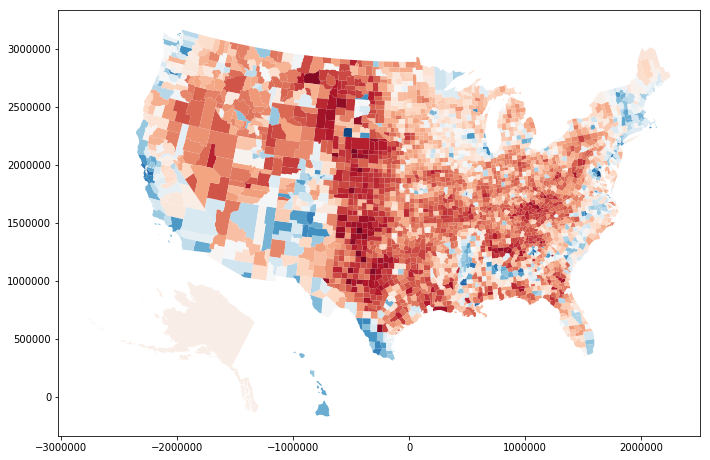

In [9]:
fig, ax = plt.subplots(figsize=(11.5,8))
ax.set_aspect('equal')
qp.quickplot(election, column='goppc', cmap='RdBu_r')

In [45]:
import networkx as nx
import pysal as ps

# We are going to store the neighborhood relations
# in a graph data structure provided by networkx
G = nx.Graph()

# neighborhoods determined by pysal operation
neighbors = ps.weights.Contiguity.Rook.from_dataframe(election)

# note that there are some islands (i.e. Alaska and Hawaii)
# also some others that I have build 'land bridges' for...


# now make the graph, add nodes first
G.add_nodes_from(range(len(election.state)))

# now read the pysal neighbors structure
# and add edges to the graph accordingly
for i, Ni in neighbors: 
    edges = [(i, j) for j in Ni]
    G.add_edges_from(edges)

# and now add the state affiliation of each as a node attribute
for i in G.nodes():
    G.node[i]['state'] = election.loc[i].state
    

/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/dosullivan/anaconda/envs/py3/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 67, 518, 519, 520, 521
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [46]:
centroids = election.geometry.centroid
n_links = gpd.GeoSeries([shapely.geometry.linestring.LineString([centroids.geometry[e[0]], 
                                                                 centroids.geometry[e[1]]]) for e in G.edges()])

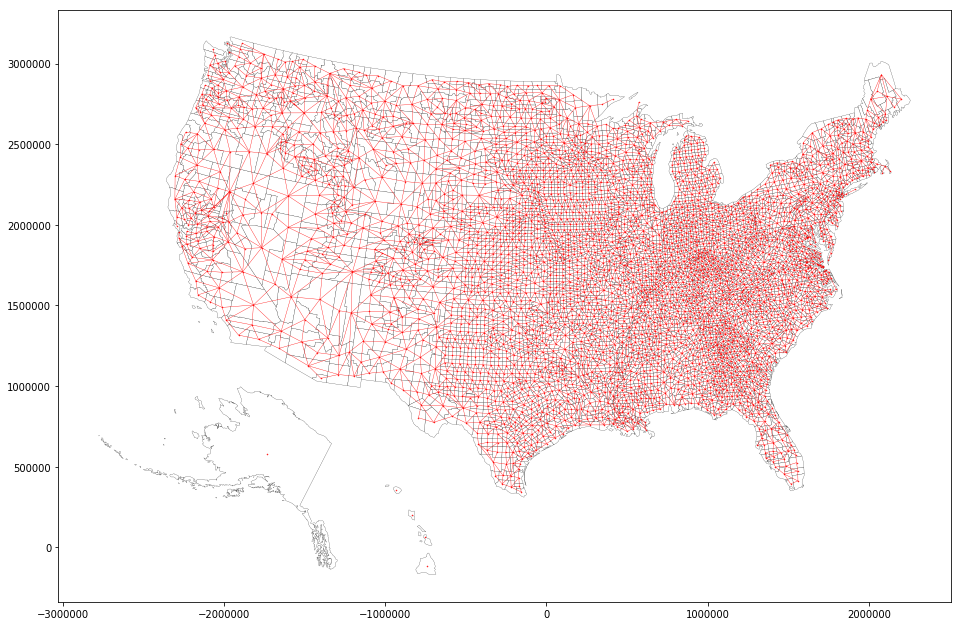

In [47]:
fig = plt.figure(figsize=(16,12))
qp.quickplot(election, facecolor='w', edgecolor='k', linewidth=0.2)
qp.quickplot(n_links, edgecolor='#ff0000', linewidth=0.35)
qp.quickplot(centroids, markersize=1, color='r')

In [48]:
import random # python built in random library

# now make some 'seed' counties
state_ids = set(election.state)
seeds = []
for s in state_ids:
    this_state = [n[0] for n in G.nodes(data=True) if n[1]['state'] == s]
    seeds.append(random.choice(this_state))

In [49]:
# now make a dictionary recording for each node
# shortest path, the source seed, and state ID
# initialize these to very long (1000), -1 (non-existent) and 'XX'
node_shortest_paths = {n: (1000, -1, "XX") for n in G.nodes()}
# for the islands, initialize so that the values won't be overwritten
for x in neighbors.islands:
    node_shortest_paths[x] = (0, 0, election.loc[x].state)

In [50]:
# Determine shortest paths to all nodes from the seed counties
distances_from_seeds = [nx.single_source_shortest_path_length(G, n) for n in seeds]
# Now iterate
for (seed, distances, state_id) in zip(seeds, distances_from_seeds, state_ids):
    for target, d in distances.items():
        if d < node_shortest_paths[target][0]:
            node_shortest_paths[target] = (d, seed, state_id)

In [51]:
nearest_states = [node_shortest_paths[i][2] for i in node_shortest_paths]
election.newstate = nearest_states

In [52]:
def make_states(c, st='state'):
    st = c.dissolve(by=st, aggfunc='sum', as_index=False)
    st.dempc = st.dem / st.votes
    st.goppc = st.gop / st.votes
    st.margin = st.goppc - st.dempc
    st['win'] = 'D'
    st.loc[st.gop > st.dem, 'win'] = 'R'
    return st

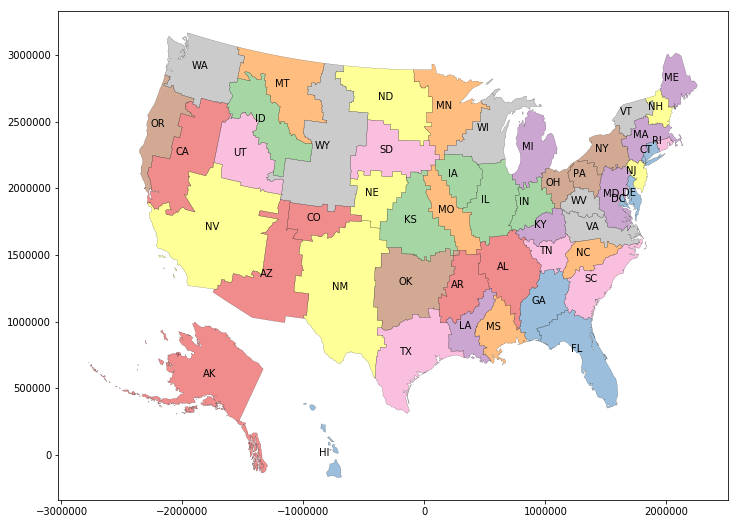

In [56]:
states = make_states(election, st='newstate')

fig, ax = plt.subplots(figsize=(12,9))
for p, t in zip(states.geometry, states.newstate):
    ax.annotate(xy=(p.centroid.x-100000, p.centroid.y), s=t)
states.plot(ax=ax, column='newstate', cmap="Set1", linewidth=0.15)

In [38]:
def get_max_idx(L):
    max_i = 0
    for i in range(len(L)):
        if L[i] >= L[max_i]:
            max_i = i
    return max_i

def remove_i(L, i):
    return L[:i] + L[i+1:]

def insert_i(L, i, x):
    return L[:i] + [x] + L[i:]

def apportion(pops, states, seats_to_assign=435, initial=1, extras=2, exclude='DC'):
    pops = list(pops)
    states = list(states)
    assigned = [initial] * len(pops)
    ex = states.index(exclude)
    assigned = remove_i(assigned, ex)
    pops = remove_i(pops, ex)
    remaining = seats_to_assign - sum(assigned)
    while remaining > 0:
        priorities = [p / np.sqrt(a * (a + 1)) for p, a in zip(pops, assigned)]
        max_priority = get_max_idx(priorities)
        assigned[max_priority] += 1
        remaining -= 1
    assigned = insert_i(assigned, ex, 1)
    assigned = [__ + 2 for __ in assigned]
    return assigned

def run_election(df, st='state', pop='population', ev='ev'):
    states = make_states(election, st)
    states[ev] = apportion(states[pop], states[st])
    return {'gop': sum(states.ev[states.win == 'R']), 'dem': sum(states.ev[states.win == 'D'])}

In [39]:
run_election(election, st='newstate')

{'dem': 256, 'gop': 282}

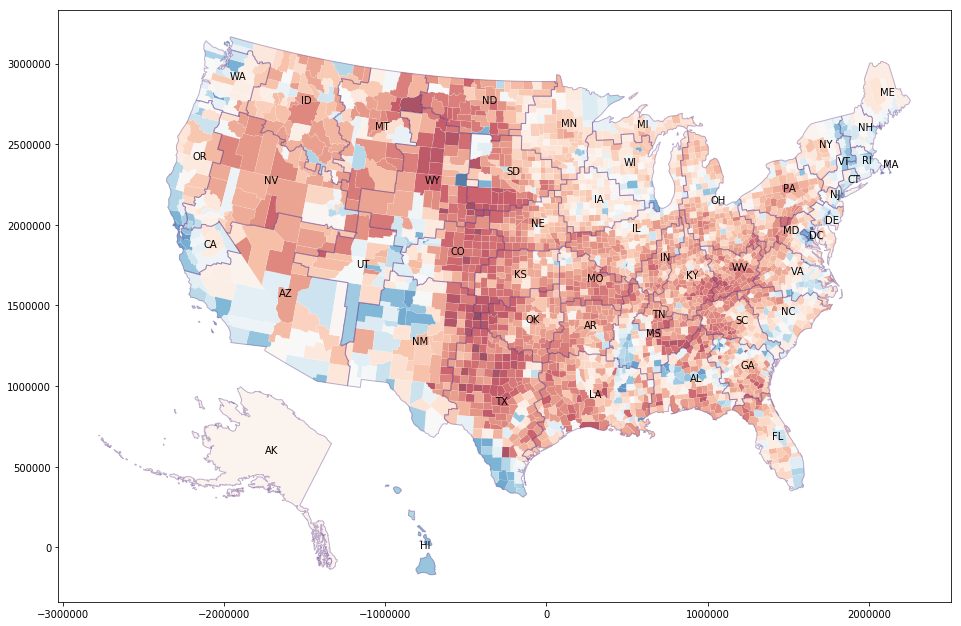

In [40]:
fig, ax = plt.subplots(figsize=(16,12))
ax.set_aspect('equal')
for p, t in zip(states.geometry, states.newstate):
    ax.annotate(xy=(p.centroid.x-10000, p.centroid.y), s=t)
qp.quickplot(election, column='goppc', cmap='RdBu_r', linewidth=0.1, edgecolor='w', alpha=1.0)
qp.quickplot(states, edgecolor='#330066', linewidth=1, facecolor='w', alpha=0.3)